In [ ]:
!pip install statsmodels

import pandas_datareader.data as web
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
# Code to download the IGAE index from the INEGI site:
token = 'c4559227-83d3-aeb4-1a8d-bee73f627140'

igae_id = '737121'

url =  f'https://www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/{igae_id}/es/0700/false/BIE/2.0/{token}?type=json'

response = requests.get(url)
data = response.json()
series = data.get('Series', [])
observations = series[0].get('OBSERVATIONS', [])
igaedf = pd.DataFrame(observations)
# Convert the month to a date type variable:
igaedf['TIME_PERIOD'] = pd.to_datetime(igaedf['TIME_PERIOD'], format='%Y/%m')
# Convert the IGAE index to a numeric variable:
igaedf['OBS_VALUE'] = pd.to_numeric(igaedf['OBS_VALUE'], errors='coerce')
# Keep only the columns we need
igaedf = igaedf[['TIME_PERIOD', 'OBS_VALUE']]
# Rename the columns:
igaedf.columns = ['Month', 'IGAE']
# Setting the month as the index of the series:
igaedf = igaedf.set_index('Month')
# Sorting the data according to the index:
igaedf = igaedf.sort_index()
# Display the first few rows
print(igaedf.head())

                 IGAE
Month                
1993-01-01  55.434736
1993-02-01  56.456971
1993-03-01  58.900549
1993-04-01  57.135844
1993-05-01  57.891853


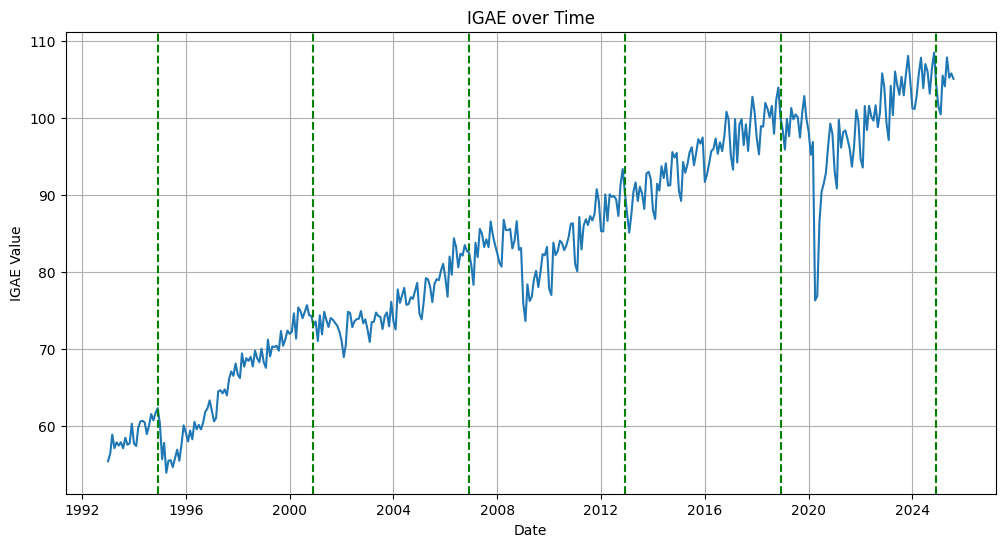

In [ ]:
# prompt: plot the IGAE from df, and trace a vertical line in Dec 2018 and Dec 2024

plt.figure(figsize=(12, 6))
plt.plot(igaedf.index, igaedf['IGAE'])
plt.title('IGAE over Time')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)

# Trace vertical lines to identify the 6-year government periods
plt.axvline(pd.to_datetime('1994-12-01'), color='green', linestyle='--')
plt.axvline(pd.to_datetime('2000-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2006-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2012-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2018-12-01'), color='green',linestyle='--')
plt.axvline(pd.to_datetime('2024-12-01'), color='green',linestyle='--')

plt.show()

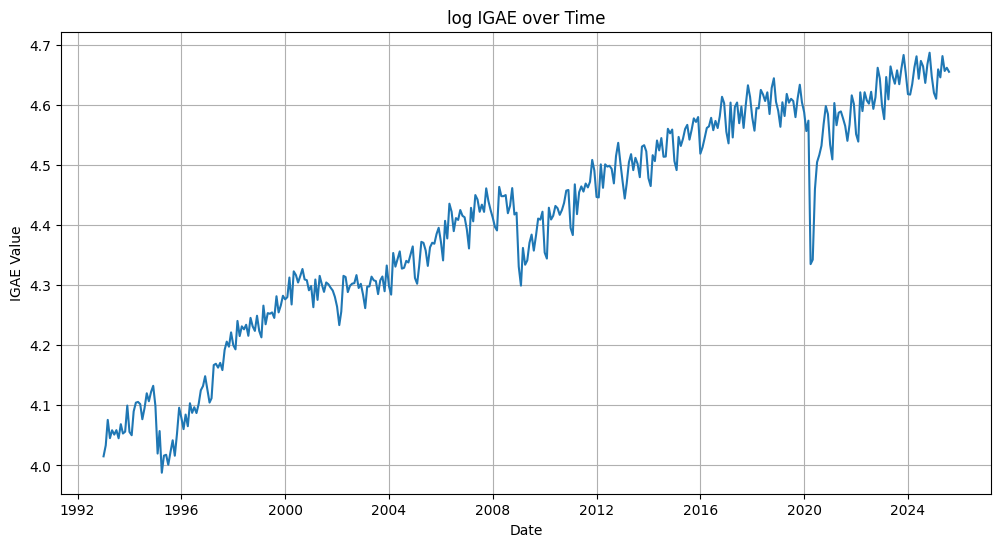

In [ ]:
igaedf['logIGAE'] = np.log(igaedf['IGAE'])

plt.figure(figsize=(12, 6))
plt.plot(igaedf.index, igaedf['logIGAE'])
plt.title('log IGAE over Time')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)
plt.show()

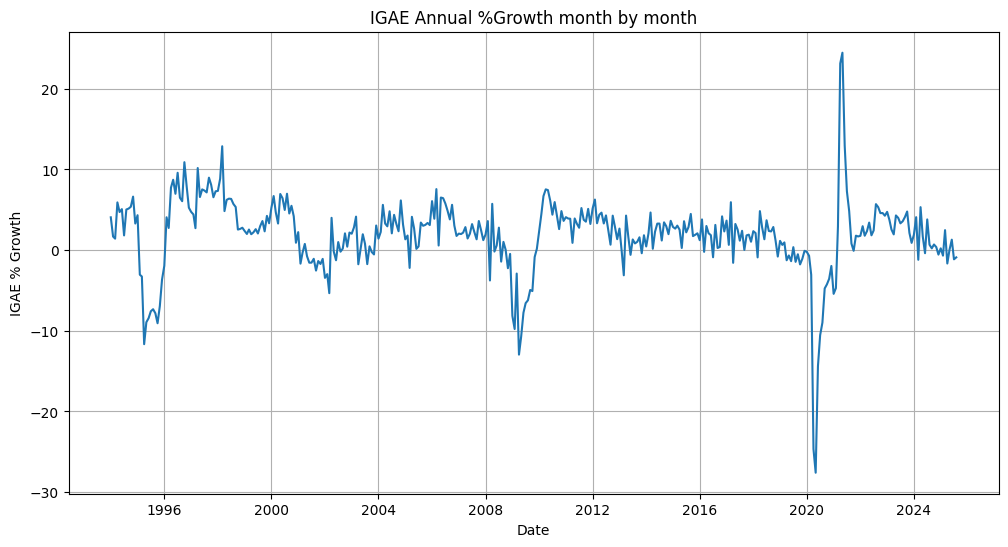

In [ ]:
igaedf['annualgrowth'] = igaedf['logIGAE'] - igaedf['logIGAE'].shift(12)
# We can also do this annual growth by using the diff function:
# igaedf['annualgrowth2'] = igaedf['logIGAE'].diff(12)

plt.figure(figsize=(12, 6))
plt.plot(igaedf.index, 100*igaedf['annualgrowth'])
plt.title('IGAE Annual %Growth month by month')
plt.xlabel('Date')
plt.ylabel('IGAE % Growth')
plt.grid(True)
plt.show()

In [ ]:
dftest = adfuller(igaedf['annualgrowth'].dropna())

# Print the results
print('ADF Statistic: %f' % dftest[0])

ADF Statistic: -3.962962


In [ ]:
print('p-value: %f' % dftest[1])
print('Critical Values:')
for key, value in dftest[4].items():
  print('\t%s: %.3f' % (key, value))

p-value: 0.001617
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


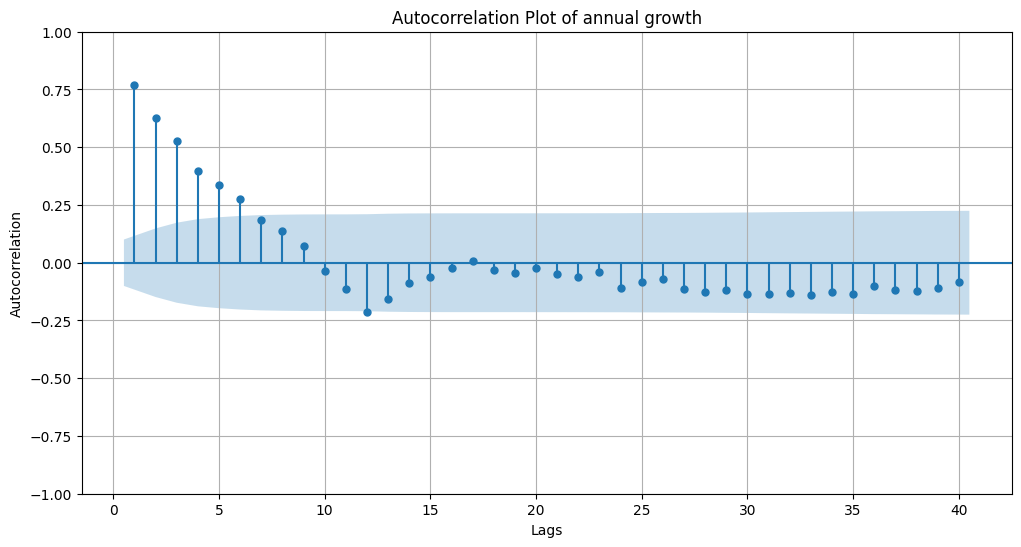

In [ ]:
# prompt: Using igaedf, Do an autocorrelation plot and a partial autocorrelation plot of 'annualgrowth'

# Drop NaN values created by the differencing
annual_growth = igaedf.dropna(subset=['annualgrowth'])

# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(annual_growth['annualgrowth'], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of annual growth')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

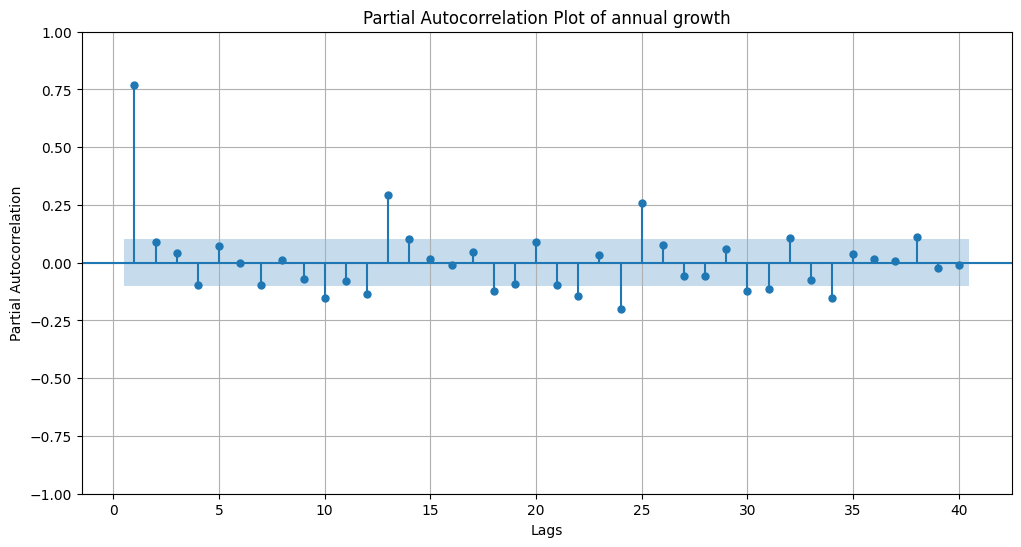

In [ ]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(annual_growth['annualgrowth'], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of annual growth')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

In [ ]:
igae_log = igaedf['logIGAE'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=0,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 0),
                seasonal_order=(0, 1, 0, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            logIGAE   No. Observations:                  392
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                 801.153
Date:                            Thu, 13 Nov 2025   AIC                          -1596.306
Time:                                    04:59:27   BIC                          -1584.486
Sample:                                01-01-1993   HQIC                         -1591.616
                                     - 08-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0043      0.002      2.859      0.004       0.001       0.007
ar.L1          0.7694      0.021   

In [ ]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)

phi0 = intercept = 0.004334
phi1 = 0.769374


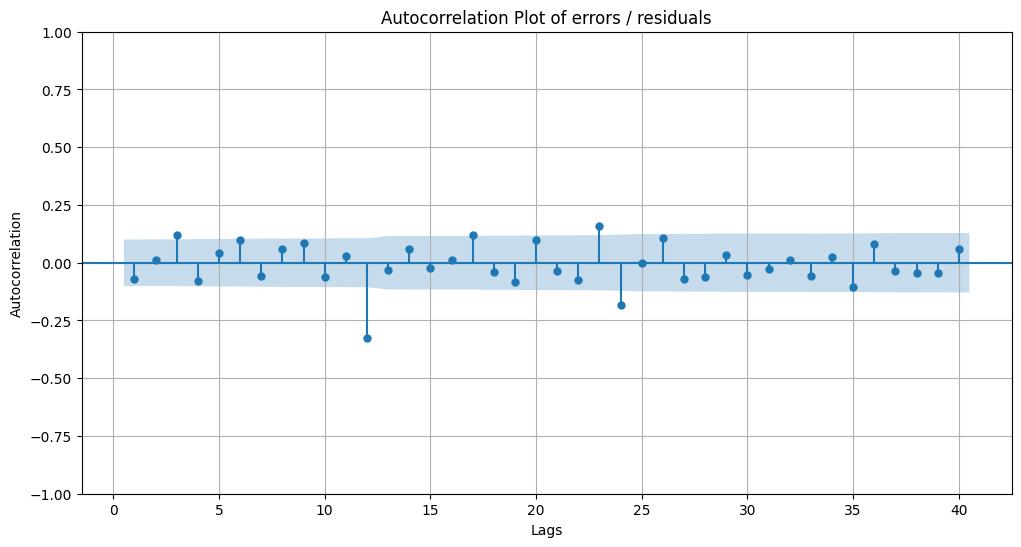

In [ ]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

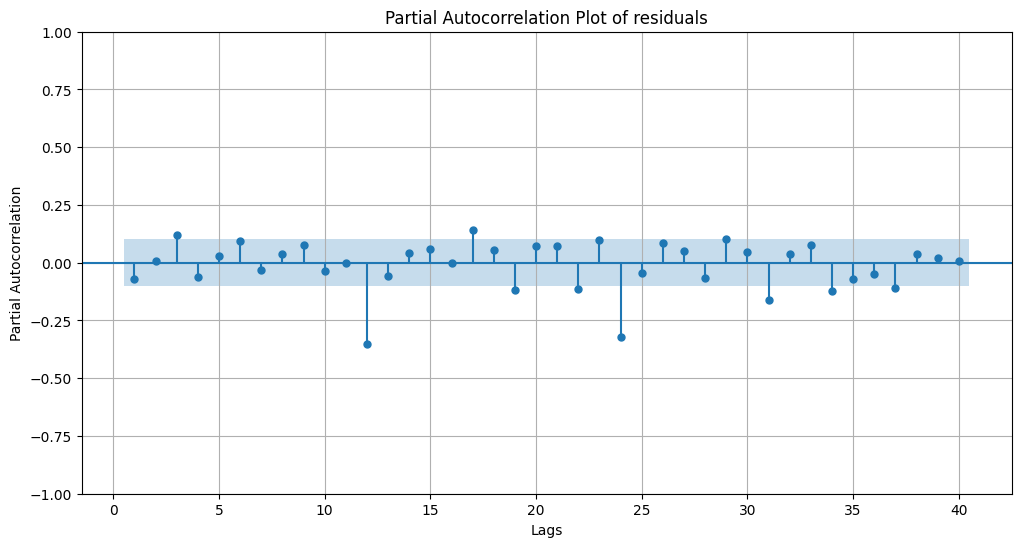

In [ ]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

In [ ]:
igae_log = igaedf['logIGAE'].dropna()

# Fit SARIMA model ARIMA(p=1,d=0,q=0) SARIMA(P=0,D=1,Q=1,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                              logIGAE   No. Observations:                  392
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                 864.452
Date:                              Thu, 13 Nov 2025   AIC                          -1720.904
Time:                                      04:59:36   BIC                          -1705.144
Sample:                                  01-01-1993   HQIC                         -1714.650
                                       - 08-01-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0026      0.000      6.752      0.000       0.002       0.003
ar.L1          0.86

In [ ]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
theta1 = result.params['ma.S.L12']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)
print('theta1 = %f' % theta1)

phi0 = intercept = 0.002591
phi1 = 0.861471
theta1 = -0.817436


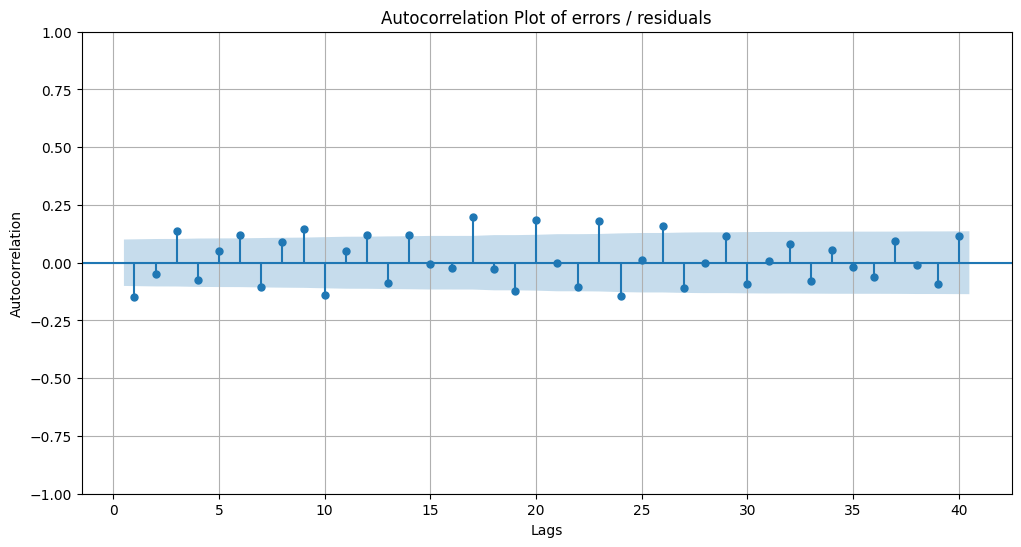

In [ ]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

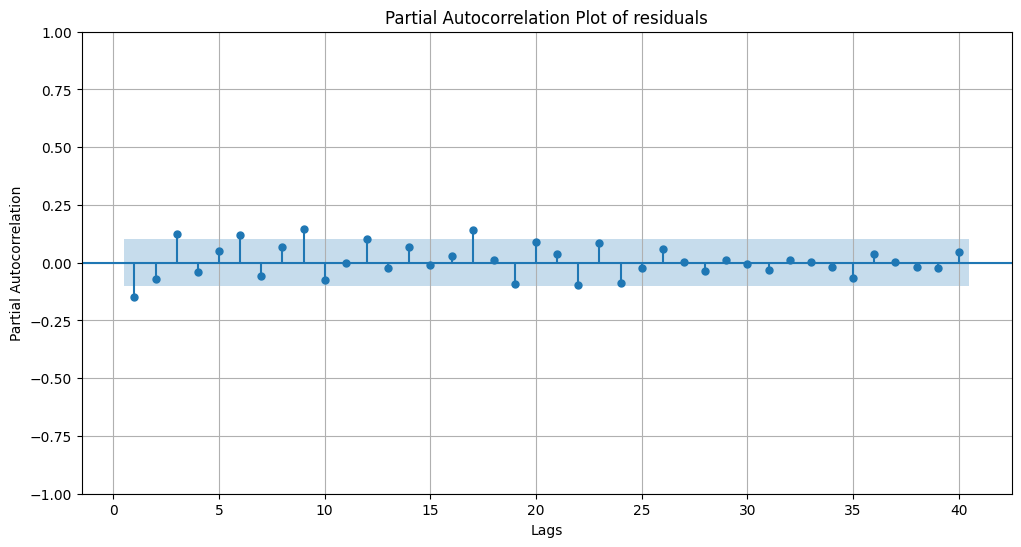

In [ ]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

In [ ]:
# Fit SARIMA model ARIMA(p=1,d=0,q=1) SARIMA(P=0,D=1,Q=1,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 1),
                seasonal_order=(0, 1, 1, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            logIGAE   No. Observations:                  392
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 864.619
Date:                            Thu, 13 Nov 2025   AIC                          -1719.239
Time:                                    04:59:42   BIC                          -1699.538
Sample:                                01-01-1993   HQIC                         -1711.421
                                     - 08-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0033      0.001      4.632      0.000       0.002       0.005
ar.L1          0.8225      0.034   

In [ ]:
phi0 = result.params['intercept']
phi1= result.params['ar.L1']
theta1 = result.params['ma.L1']
theta2 = result.params['ma.S.L12']

print('phi0 = intercept = %f' % phi0)
print('phi1 = %f' % phi1)
print('theta1 = %f' % theta1)
print('theta2 = %f' % theta2)

phi0 = intercept = 0.003325
phi1 = 0.822456
theta1 = -0.158917
theta2 = -0.786725


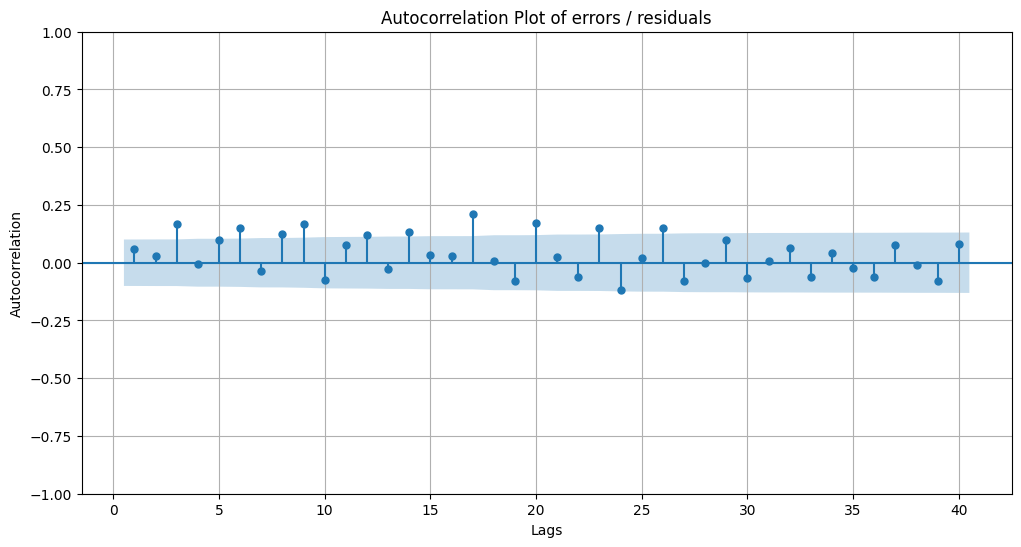

In [ ]:
# Autocorrelation plot
plt.figure(figsize=(12, 6))
plot_acf(result.resid.iloc[12:], lags=40, zero=False, ax=plt.gca())
plt.title('Autocorrelation Plot of errors / residuals')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

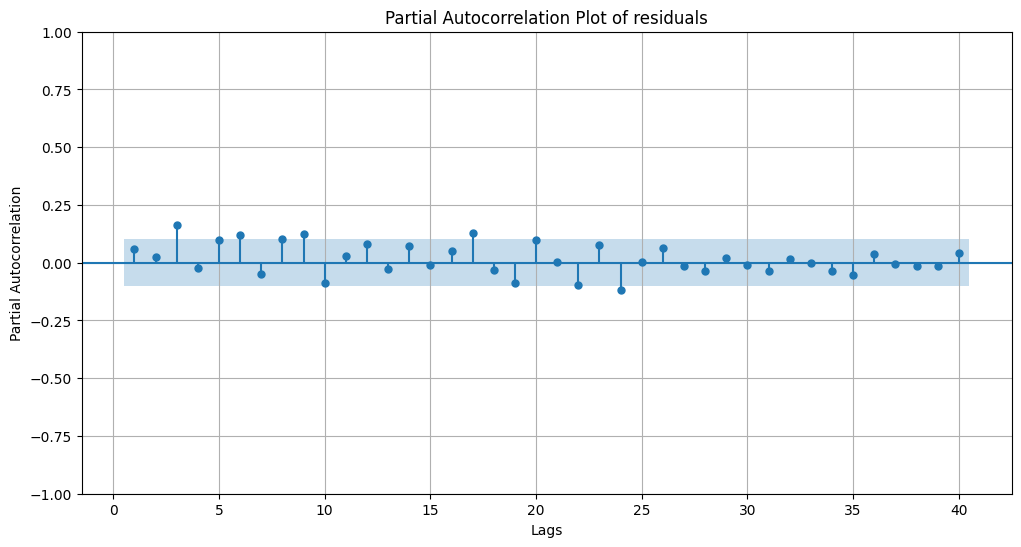

In [ ]:
# Partial autocorrelation plot
plt.figure(figsize=(12, 6))
plot_pacf(result.resid.iloc[12:], zero=False, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Plot of residuals')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid(True)
plt.show()

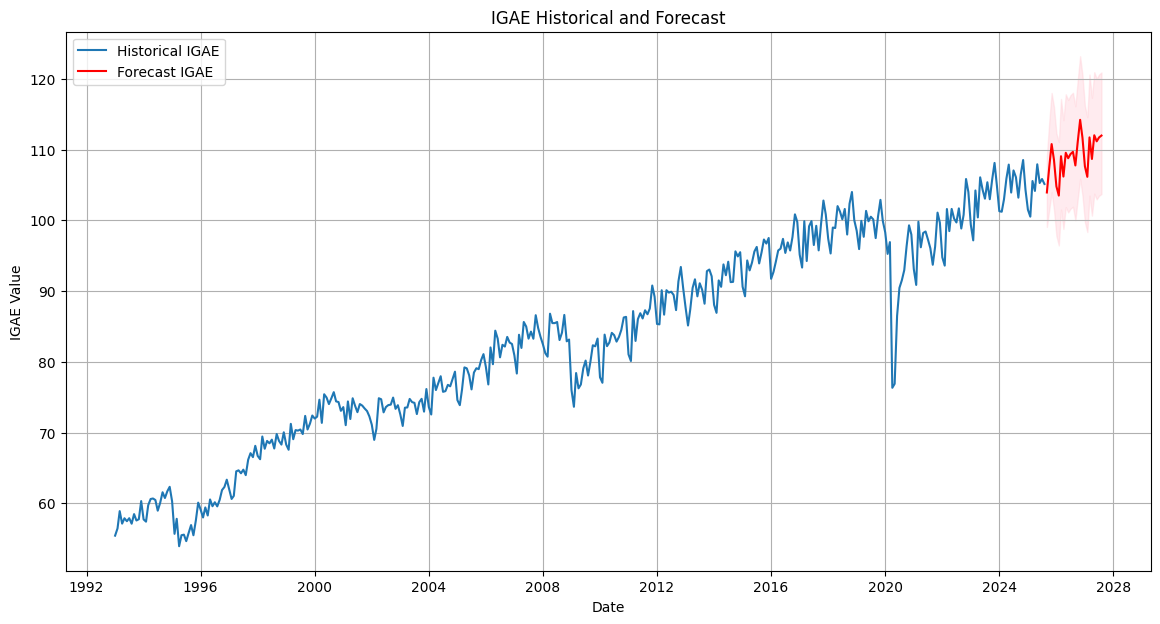

In [ ]:
# I will forecast 24 months in the future:
forecast_steps = 24
forecast_result = result.get_forecast(steps=forecast_steps)
# I get the mean forecast:
forecast_log = forecast_result.predicted_mean
# Get the 95% confidence interval of the forecast:
# alpha = 1 - confidence interval
forecast_ci = forecast_result.conf_int(alpha=0.05)

# Convert log forecast values back to original scale of IGAE
forecast_values = np.exp(forecast_log)

# Plot historical and forecast values
plt.figure(figsize=(14, 7))
plt.plot(igaedf.index, igaedf['IGAE'], label='Historical IGAE')
plt.plot(forecast_values.index, forecast_values, label='Forecast IGAE', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]), color='pink', alpha=0.3) # Plot confidence interval

plt.title('IGAE Historical and Forecast')
plt.xlabel('Date')
plt.ylabel('IGAE Value')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Fit SARIMA model ARIMA(p=1,d=0,q=1) SARIMA(P=0,D=1,Q=1,#periods=12)
model = SARIMAX(igae_log, order=(1, 0, 1),
                seasonal_order=(0, 1, 1, 12),
                trend='c') # Include drift/constant term
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            logIGAE   No. Observations:                  392
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 864.619
Date:                            Thu, 13 Nov 2025   AIC                          -1719.239
Time:                                    04:59:49   BIC                          -1699.538
Sample:                                01-01-1993   HQIC                         -1711.421
                                     - 08-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0033      0.001      4.632      0.000       0.002       0.005
ar.L1          0.8225      0.034   

#**CHALLENGE 1**
Download the Real Gross Domestic Product for Mexico from the FRED online site (US Federal Reserve Bank). Use the ticker NGDPRNSAXDCMXQ. You have to:

a. Calibrate an ARIMA-SARIMA to forecast the Mexico GDP for the the rest of 2025 and all quarters of 2026.

b. You have to explain your calibration steps, and

c. Interpret the final model.

I download the Mexico GDP from the FRED web site as follows:

Primero recuperamos

In [ ]:
# Descargar serie GDP real trimestral (sin ajuste estacional)
series_id = "NGDPRNSAXDCMXQ"
mxgdpdf = web.DataReader(series_id, 'fred', start='1993-01-01')

# Renombrar columna
mxgdpdf.columns = ['GDP']
mxgdpdf.dropna(inplace=True)

# Verificar datos
print(mxgdpdf.head())

                  GDP
DATE                 
1993-01-01  3439763.5
1993-04-01  3472286.3
1993-07-01  3465719.7
1993-10-01  3519338.2
1994-01-01  3525020.1


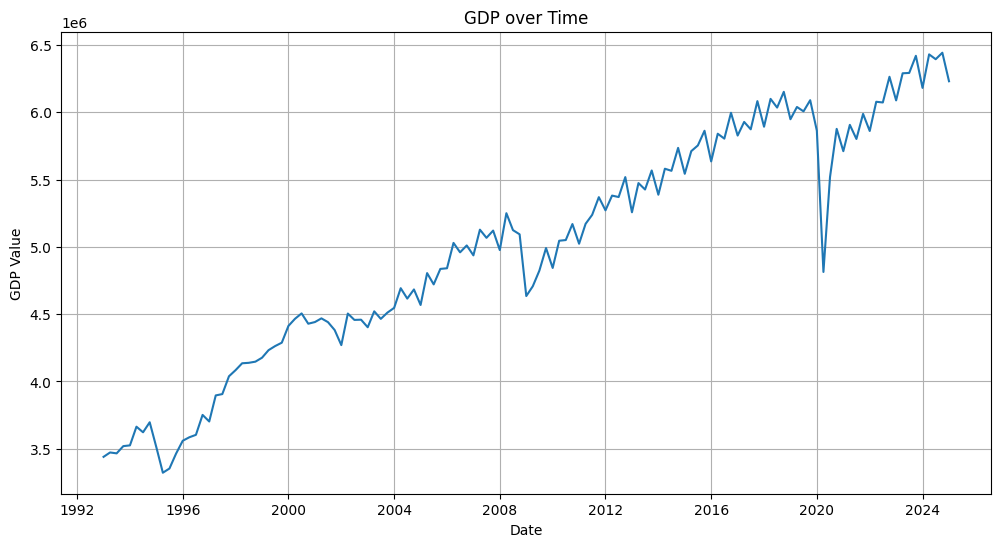

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(mxgdpdf.index, mxgdpdf['GDP'])
plt.title('GDP over Time')
plt.xlabel('Date')
plt.ylabel('GDP Value')
plt.grid(True)

Como el GDP no es una serie estacionaria por sí mismo, es necesario aplicar la diferencia estacional de los logaritmos para eliminar la tendencia y la estacionalidad.

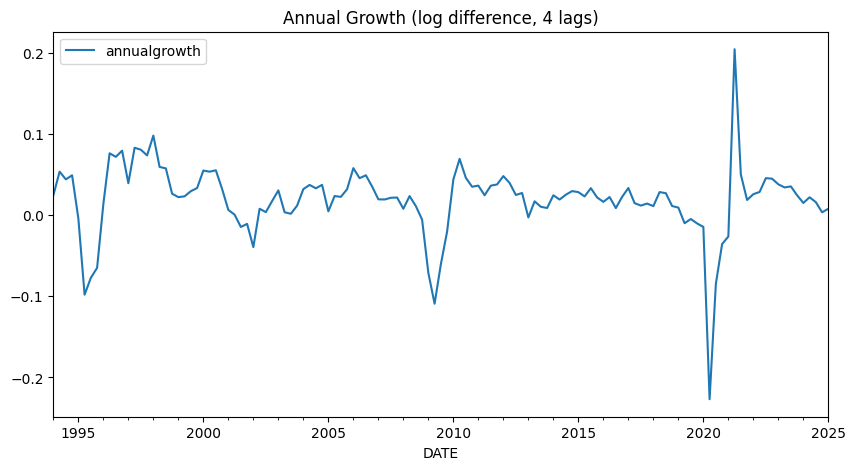

In [ ]:
mxgdpdf['logGDP']       = np.log(mxgdpdf['GDP'])
mxgdpdf['annualgrowth'] = mxgdpdf['logGDP'] - mxgdpdf['logGDP'].shift(4) #por los 4 periodos del trimestre

mxgdpdf.dropna(inplace=True)
mxgdpdf.plot(y='annualgrowth', figsize=(10,5), title='Annual Growth (log difference, 4 lags)')
plt.show()

Dado que a simple vista no podemos determinar si la serie es estacionaria, es necesario realizar una prueba de Dickey-Fuller aumentada (ADF).

In [ ]:
adfResult = adfuller(mxgdpdf["annualgrowth"])
print("ADF Statistic:", adfResult[0])
print("p-value:", adfResult[1])
for key, value in adfResult[4].items():
    print(f"   {key}: {value:.3f}")

ADF Statistic: -3.5279298734184197
p-value: 0.007298108645771897
   1%: -3.488
   5%: -2.887
   10%: -2.580


Como el valor p obtenido es mayor a 0.05, concluimos que esta versión de la variable no es estacionaria. Una vez confirmado esto, procedemos a realizar los correlogramas de autocorrelaciones (ACF) y autocorrelaciones parciales (PACF).

<Figure size 1200x600 with 0 Axes>

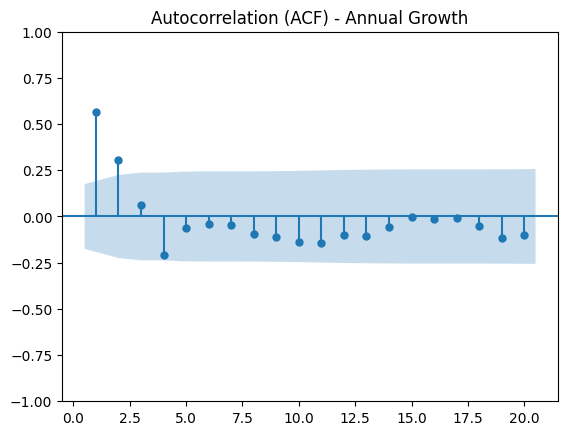

<Figure size 1200x600 with 0 Axes>

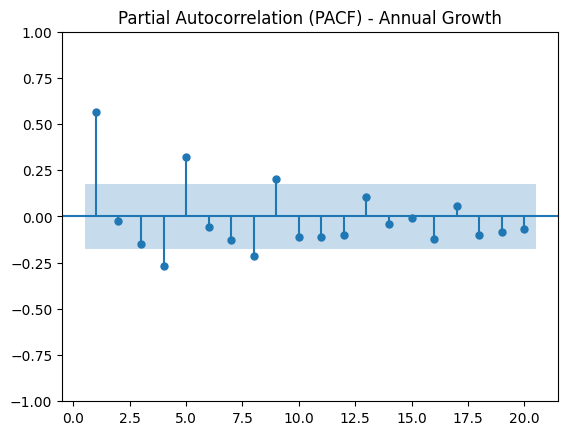

In [ ]:
plt.figure(figsize=(12,6))
plot_acf(mxgdpdf['annualgrowth'], lags=20, zero=False)
plt.title('Autocorrelation (ACF) - Annual Growth')
plt.show()

plt.figure(figsize=(12,6))
plot_pacf(mxgdpdf['annualgrowth'], lags=20, zero=False)
plt.title('Partial Autocorrelation (PACF) - Annual Growth')
plt.show()

Debido a que estamos aplicando una diferencia estacional (D = 1) y una primera diferencia (d = 0), y observamos que la ACF decae gradualmente mientras que la PACF corta bruscamente, deducimos que la serie sigue un patrón autorregresivo (AR). Por lo tanto, establecemos q = 0 y p = 1. Mantendremos por ahora los valores de P y Q en 0 para observar el comportamiento inicial del modelo.

In [ ]:
model = SARIMAX(mxgdpdf['logGDP'], order=(1, 0, 0),
                seasonal_order=(0, 1, 0, 4), trend='c')
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                            logGDP   No. Observations:                  125
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 4)   Log Likelihood                 229.205
Date:                           Thu, 13 Nov 2025   AIC                           -452.410
Time:                                   04:59:53   BIC                           -444.022
Sample:                               01-01-1994   HQIC                          -449.003
                                    - 01-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0079      0.003      2.362      0.018       0.001       0.014
ar.L1          0.5662      0.064      8.893

Tanto φ₀ (phi0) como φ₁ (phi1) resultan estadísticamente significativos, con valores p menores a 0.05. El parámetro φ₀ indica que el crecimiento trimestral del PIB es de aproximadamente 0.79%, mientras que φ₁ sugiere que el 56% del logaritmo del PIB se transmite al siguiente trimestre. A continuación, realizamos nuevos correlogramas para analizar los residuos del modelo.

<Figure size 1200x600 with 0 Axes>

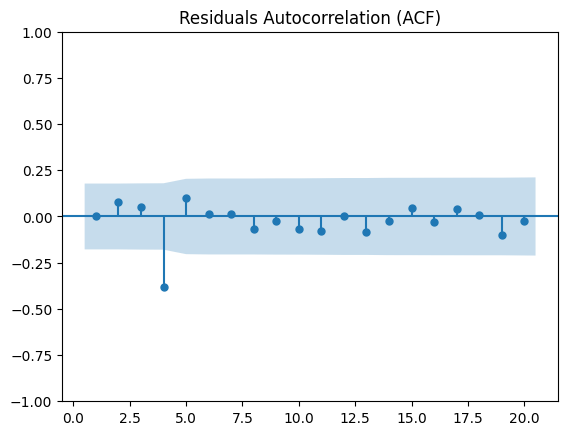

<Figure size 1200x600 with 0 Axes>

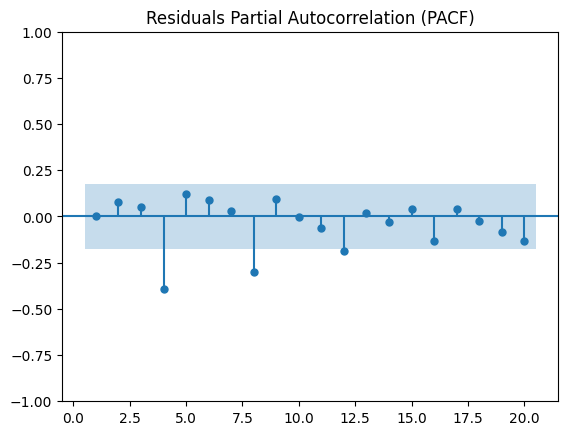

In [ ]:
plt.figure(figsize=(12,6))
plot_acf(result.resid.iloc[4:], lags=20, zero=False)
plt.title('Residuals Autocorrelation (ACF)')
plt.show()

plt.figure(figsize=(12,6))
plot_pacf(result.resid.iloc[4:], lags=20, zero=False)
plt.title('Residuals Partial Autocorrelation (PACF)')
plt.show()

En los residuos se observa que la autocorrelación significativa es negativa en ambos gráficos, lo que indica la necesidad de incluir un término MA estacional, pero ningún término AR adicional. Por ello, establecemos P = 0 y Q = 1.

In [ ]:
model = SARIMAX(mxgdpdf['logGDP'], order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 4), trend='c')
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                              logGDP   No. Observations:                  125
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 251.120
Date:                             Thu, 13 Nov 2025   AIC                           -494.241
Time:                                     04:59:56   BIC                           -483.058
Sample:                                 01-01-1994   HQIC                          -489.699
                                      - 01-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0035      0.001      5.002      0.000       0.002       0.005
ar.L1          0.8079      

Tanto φ₀ como φ₁ continúan siendo significativos. En este caso, φ₁ indica que el 81% del crecimiento del PIB se transmite al siguiente trimestre, mientras que φ₀ señala que la media del crecimiento trimestral del PIB es de aproximadamente 0.35%. Finalmente, el parámetro θ₁ (theta1), con un valor de -0.98, indica la presencia de un fuerte componente estacional que corrige choques trimestrales pasados. En conclusión, este modelo muestra un mejor ajuste que el anterior, con resultados estadísticamente significativos y valores positivos. Posteriormente, elaboramos un nuevo correlograma de los residuos para verificar si se requieren más ajustes.

<Figure size 1200x600 with 0 Axes>

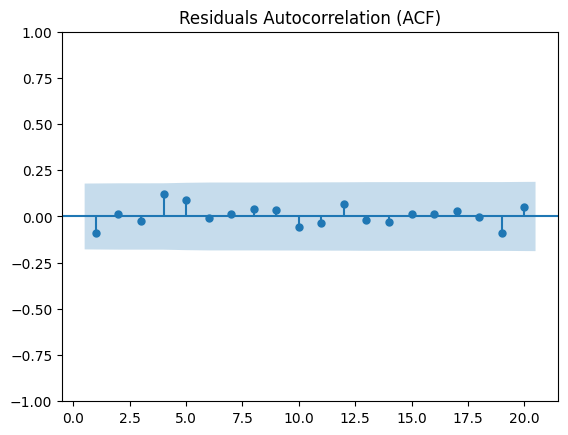

<Figure size 1200x600 with 0 Axes>

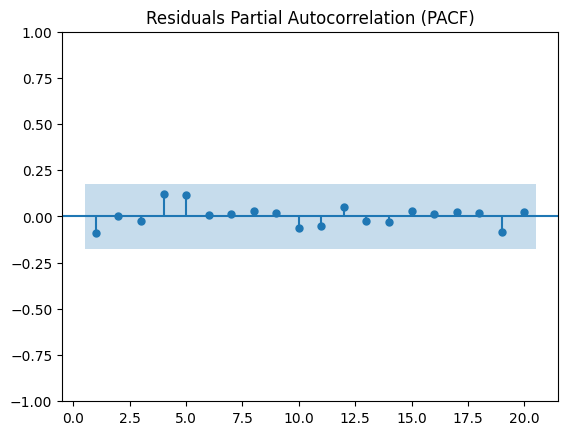

In [ ]:
plt.figure(figsize=(12,6))
plot_acf(result.resid.iloc[4:], lags=20, zero=False)
plt.title('Residuals Autocorrelation (ACF)')
plt.show()

plt.figure(figsize=(12,6))
plot_pacf(result.resid.iloc[4:], lags=20, zero=False)
plt.title('Residuals Partial Autocorrelation (PACF)')
plt.show()

Como se puede observar, ningún valor sobrepasa el intervalo de confianza del 95%, por lo que podemos considerar el modelo adecuado.

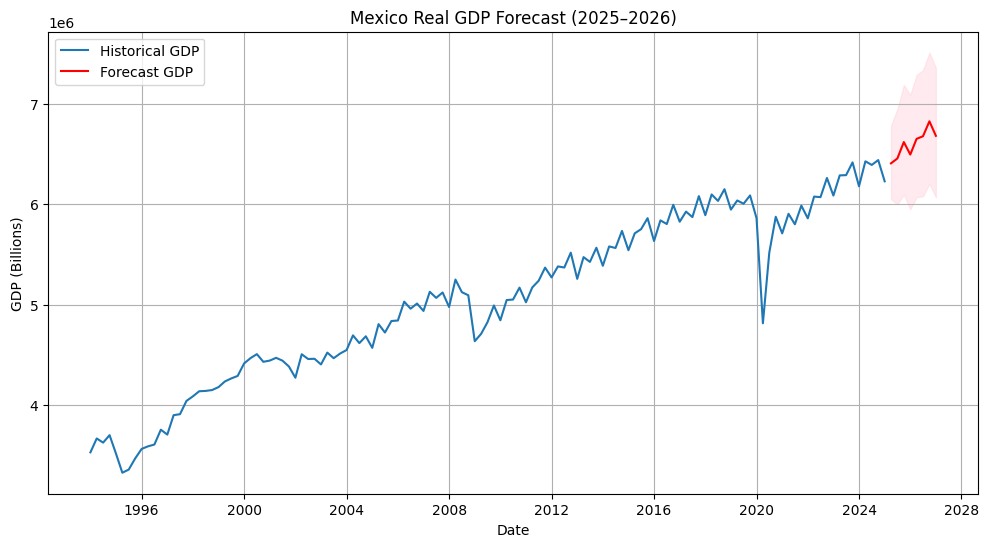

In [ ]:
forecast_steps = 8  # 2 años = 8 trimestres
forecast_result = result.get_forecast(steps=forecast_steps)

forecast_log = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.05)

forecast_values = np.exp(forecast_log)

plt.figure(figsize=(12,6))
plt.plot(mxgdpdf.index, mxgdpdf['GDP'], label='Historical GDP')
plt.plot(forecast_values.index, forecast_values, label='Forecast GDP', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]),
                 color='pink', alpha=0.3)
plt.title('Mexico Real GDP Forecast (2025–2026)')
plt.xlabel('Date')
plt.ylabel('GDP (Billions)')
plt.legend()
plt.grid(True)
plt.show()

#**CHALLENGE 2**

Do the same as above, but now for the US Real GDP:

Download the Real Gross Domestic Product for the US from the FRED online site (US Federal Reserve Bank). Use the ticker NGDPRNSAXDCMXQ. You have to:

a. Calibrate an ARIMA-SARIMA to forecast the US GDP for the the rest of 2025 and all quarters of 2026.

b. Using your previous Mexico SARIMA model, use the US GDP annual % growth as an explanatory variable (exogenous variable).

c. Interpret the final model.

Repetimos procesos

In [ ]:
# Descargar serie GDP real trimestral (sin ajuste estacional)
series_id = "NGDPRNSAXDCMXQ"
usagdpdf = web.DataReader(series_id, 'fred', start='1993-01-01')

# Renombrar columna
usagdpdf.columns = ['GDP']
usagdpdf.dropna(inplace=True)

# Verificar datos
print(usagdpdf.head())

                  GDP
DATE                 
1993-01-01  3439763.5
1993-04-01  3472286.3
1993-07-01  3465719.7
1993-10-01  3519338.2
1994-01-01  3525020.1


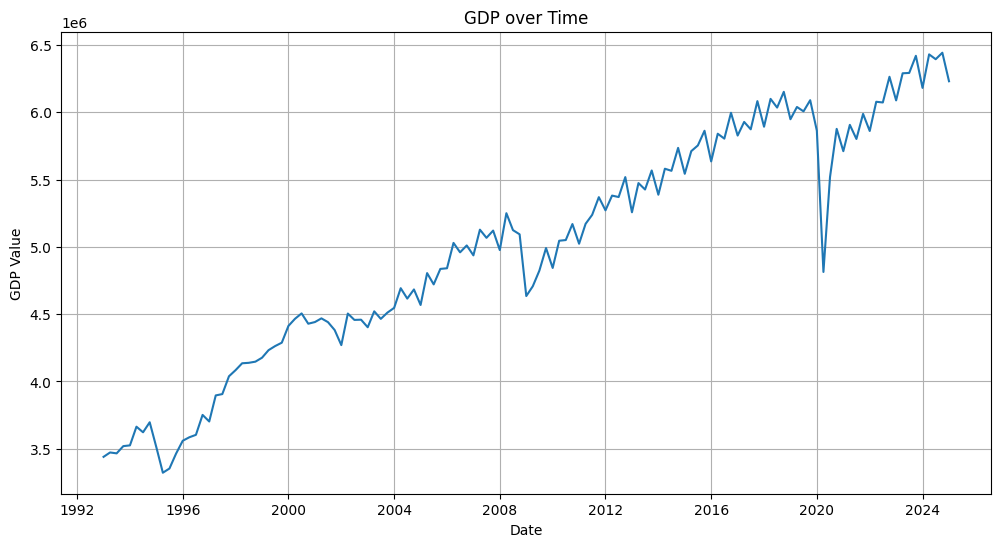

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(usagdpdf.index, usagdpdf['GDP'])
plt.title('GDP over Time')
plt.xlabel('Date')
plt.ylabel('GDP Value')
plt.grid(True)

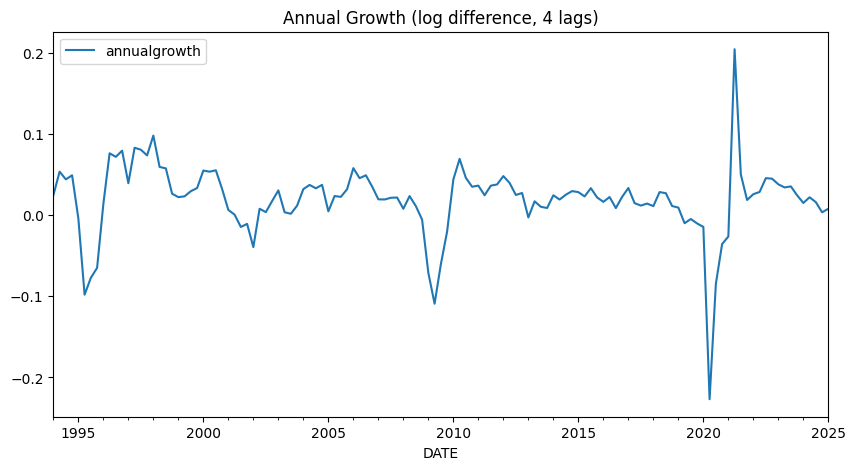

In [ ]:
usagdpdf['logGDP']       = np.log(usagdpdf['GDP'])
usagdpdf['annualgrowth'] = usagdpdf['logGDP'] - usagdpdf['logGDP'].shift(4) #por los 4 periodos del trimestre

usagdpdf.dropna(inplace=True)
usagdpdf.plot(y='annualgrowth', figsize=(10,5), title='Annual Growth (log difference, 4 lags)')
plt.show()

Esta variable es estacionaria

In [ ]:
adfResult = adfuller(usagdpdf["annualgrowth"])
print("ADF Statistic:", adfResult[0])
print("p-value:", adfResult[1])
for key, value in adfResult[4].items():
    print(f"   {key}: {value:.3f}")

ADF Statistic: -3.5279298734184197
p-value: 0.007298108645771897
   1%: -3.488
   5%: -2.887
   10%: -2.580


<Figure size 1200x600 with 0 Axes>

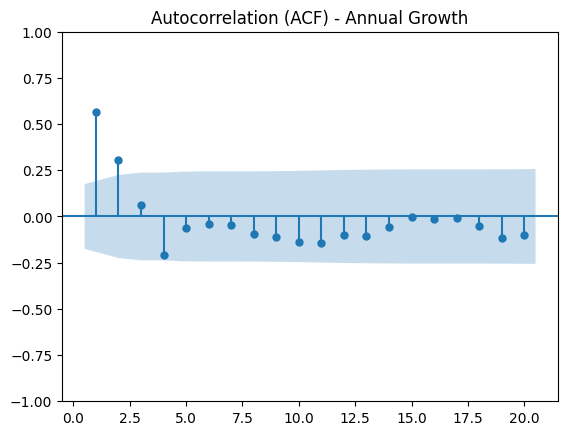

<Figure size 1200x600 with 0 Axes>

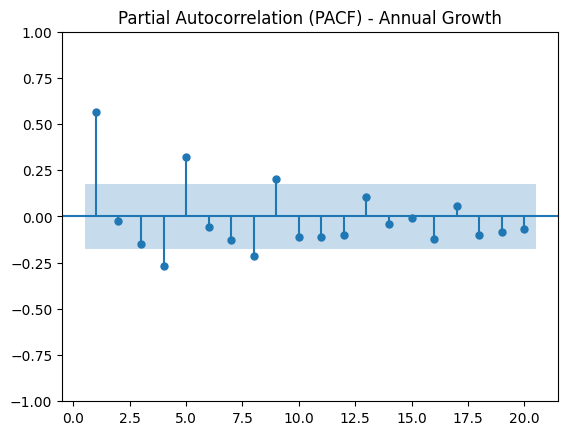

In [ ]:
plt.figure(figsize=(12,6))
plot_acf(usagdpdf['annualgrowth'], lags=20, zero=False)
plt.title('Autocorrelation (ACF) - Annual Growth')
plt.show()

plt.figure(figsize=(12,6))
plot_pacf(usagdpdf['annualgrowth'], lags=20, zero=False)
plt.title('Partial Autocorrelation (PACF) - Annual Growth')
plt.show()

Del mismo modo, dado que aplicamos D = 1 y d = 0, y observamos nuevamente que la ACF decae gradualmente y la PACF corta bruscamente, deducimos un patrón AR. Así, establecemos q = 0 y p = 1, manteniendo P y Q en 0 para observar la respuesta inicial.

In [ ]:
model = SARIMAX(usagdpdf['logGDP'], order=(1, 0, 0),
                seasonal_order=(0, 1, 0, 4), trend='c')
result = model.fit()
print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                            logGDP   No. Observations:                  125
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 4)   Log Likelihood                 229.205
Date:                           Thu, 13 Nov 2025   AIC                           -452.410
Time:                                   05:00:02   BIC                           -444.022
Sample:                               01-01-1994   HQIC                          -449.003
                                    - 01-01-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0079      0.003      2.362      0.018       0.001       0.014
ar.L1          0.5662      0.064      8.893

Los parámetros φ₀ y φ₁ son significativos según su valor p, e indican que, de acuerdo con el modelo, el crecimiento trimestral será del 0.79%, y el 56.62% del crecimiento del trimestre anterior se transmite al siguiente. Al igual que en el modelo anterior, verificamos las gráficas residuales.

<Figure size 1200x600 with 0 Axes>

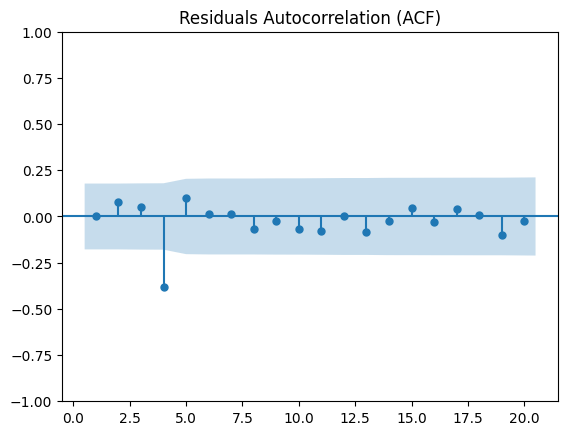

<Figure size 1200x600 with 0 Axes>

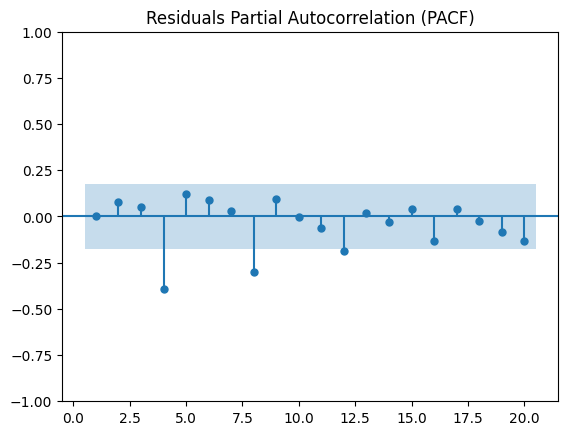

In [ ]:
plt.figure(figsize=(12,6))
plot_acf(result.resid.iloc[4:], lags=20, zero=False)
plt.title('Residuals Autocorrelation (ACF)')
plt.show()

plt.figure(figsize=(12,6))
plot_pacf(result.resid.iloc[4:], lags=20, zero=False)
plt.title('Residuals Partial Autocorrelation (PACF)')
plt.show()

En los residuos observamos nuevamente una autocorrelación negativa significativa, por lo que se selecciona un término MA estacional (Q = 1) y ningún término AR adicional (P = 0).

In [ ]:
model = SARIMAX(usagdpdf['logGDP'], order=(1, 0, 0),
                seasonal_order=(0, 1, 1, 4), trend='c')
resultUSA = model.fit()
print(resultUSA.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                              logGDP   No. Observations:                  125
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 251.120
Date:                             Thu, 13 Nov 2025   AIC                           -494.241
Time:                                     05:00:05   BIC                           -483.058
Sample:                                 01-01-1994   HQIC                          -489.699
                                      - 01-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0035      0.001      5.002      0.000       0.002       0.005
ar.L1          0.8079      

Los resultados obtenidos son estadísticamente significativos y, al igual que el modelo anterior, presentan un mejor ajuste. El parámetro φ₀ indica un crecimiento promedio trimestral de 0.35%, φ₁ refleja que el 81% del crecimiento del trimestre anterior se transmite al actual, y θ₁ = -0.97 sugiere una fuerte corrección de choques de trimestres pasados.

<Figure size 1200x600 with 0 Axes>

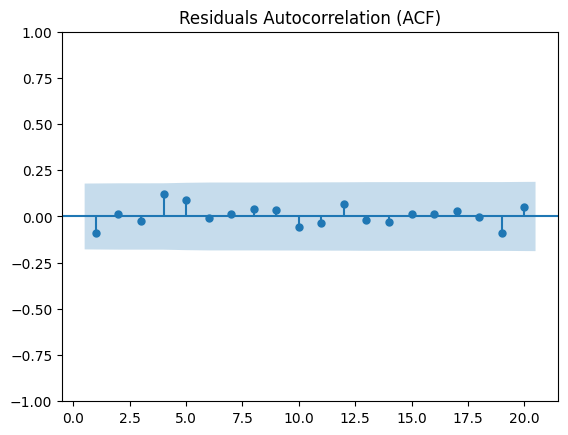

<Figure size 1200x600 with 0 Axes>

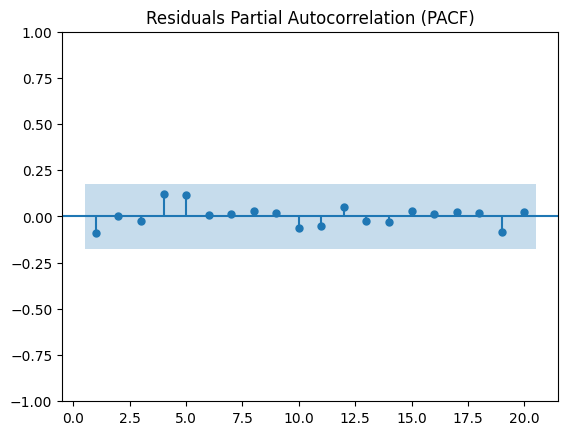

In [ ]:
plt.figure(figsize=(12,6))
plot_acf(resultUSA.resid.iloc[4:], lags=20, zero=False)
plt.title('Residuals Autocorrelation (ACF)')
plt.show()

plt.figure(figsize=(12,6))
plot_pacf(resultUSA.resid.iloc[4:], lags=20, zero=False)
plt.title('Residuals Partial Autocorrelation (PACF)')
plt.show()

Tras confirmar que no existen valores significativos fuera del 95%, procedemos a generar el pronóstico.

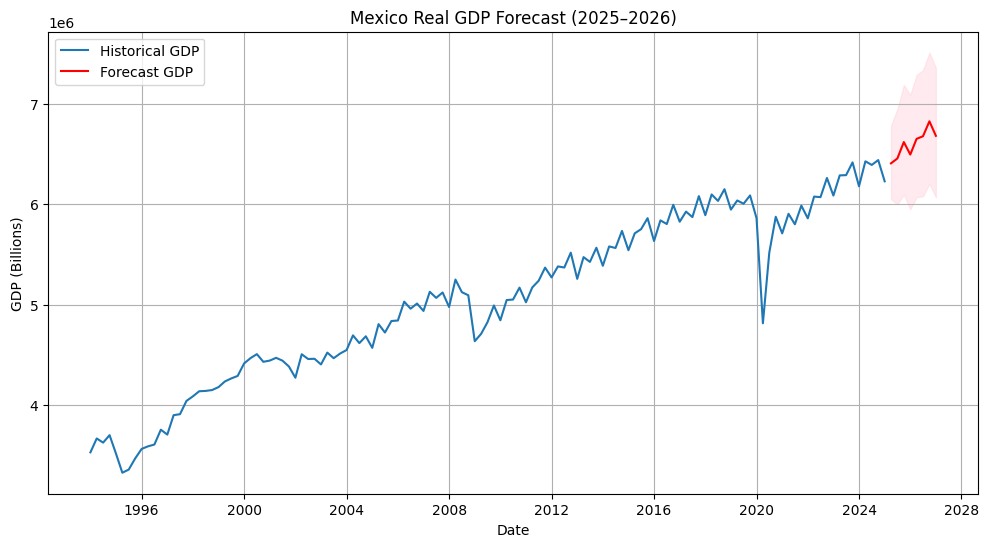

In [ ]:
forecast_steps = 8
forecast_result = resultUSA.get_forecast(steps=forecast_steps)

forecast_log = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int(alpha=0.05)

forecast_values = np.exp(forecast_log)

plt.figure(figsize=(12,6))
plt.plot(usagdpdf.index, usagdpdf['GDP'], label='Historical GDP')
plt.plot(forecast_values.index, forecast_values, label='Forecast GDP', color='red')
plt.fill_between(forecast_values.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]),
                 color='pink', alpha=0.3)
plt.title('Mexico Real GDP Forecast (2025–2026)')
plt.xlabel('Date')
plt.ylabel('GDP (Billions)')
plt.legend()
plt.grid(True)
plt.show()

Finalmente, se genera un modelo para México, utilizando el GDP como variable exógena.

In [ ]:
combined_df = pd.concat([mxgdpdf['logGDP'], usagdpdf['annualgrowth']], axis=1).dropna()

In [ ]:
model = SARIMAX(combined_df['logGDP'],order=(1, 0, 0),
    seasonal_order=(0, 1, 1, 4),trend='c',exog=combined_df[['annualgrowth']]
)
resultMEXA = model.fit()
print(resultMEXA.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                              logGDP   No. Observations:                  125
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 4)   Log Likelihood                 311.359
Date:                             Thu, 13 Nov 2025   AIC                           -612.718
Time:                                     05:06:59   BIC                           -598.739
Sample:                                 01-01-1994   HQIC                          -607.041
                                      - 01-01-2025                                         
Covariance Type:                               opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0080      0.004      2.206      0.027       0.001       0.015
annualgrowth     0.49

Este modelo, diseñado para el PIB de México e incorporando el PIB de Estados Unidos como variable exógena, muestra un valor estadísticamente significativo. La mayoría de los parámetros, como φ₀, φ₁ y θ, mantuvieron valores similares a los del modelo original. Sin embargo, se añadió una nueva variable denominada crecimiento anual, con un coeficiente de 0.5, lo que indica que por cada incremento del 1% en el PIB de Estados Unidos, el PIB de México aumenta aproximadamente un 0.5%. Este resultado refleja una fuerte dependencia económica de México respecto a la actividad económica estadounidense.

/tmp/ipython-input-2301171042.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')
/tmp/ipython-input-2301171042.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')


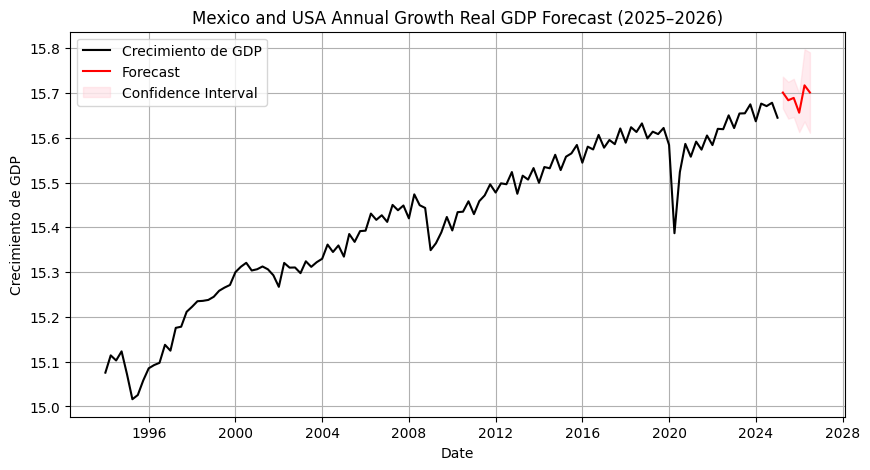

In [ ]:
forecast_usa = resultUSA.get_forecast(steps=6)
predicted_usagdp = forecast_usa.predicted_mean

predicted_growth = np.log(predicted_usagdp).diff(4)

predicted_growth = (
    predicted_growth
    .replace([np.inf, -np.inf], np.nan)
    .fillna(method='bfill')
    .fillna(method='ffill')
)

predicted_growth = predicted_growth.to_frame(name='annualGrowth')

forecast_mx = resultMEXA.get_forecast(
    steps=len(predicted_growth),
    exog=predicted_growth
)

forecast_mean = forecast_mx.predicted_mean
conf_int = forecast_mx.conf_int()

plt.figure(figsize=(10, 5))
plt.plot(mxgdpdf.index, mxgdpdf['logGDP'], label='Crecimiento de GDP', color='black')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(conf_int.index,conf_int.iloc[:, 0],conf_int.iloc[:, 1],color='pink',
                 alpha=0.3,label='Confidence Interval')
plt.title("Mexico and USA Annual Growth Real GDP Forecast (2025–2026)")
plt.xlabel("Date")
plt.ylabel("Crecimiento de GDP")
plt.legend()
plt.grid(True)
plt.show()